# Homework 4 - Question 1

 Implement the EM algorithm for fitting a Gaussian mixture model for the MNIST dataset. We reduce the dataset to be only two cases, of digits "2" and "6" only. Thus, you will fit GMM with $C = 2$. Use the data file _data.mat_ or _data.dat_ on Canvas. True label of the data are also provided in _label.mat_ and _label.dat_
 
 The matrix _images_ is of size 784-by-1990, i.e., there are totally 1990 images, and each column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized; the original image can be recovered by map the vector into a matrix.) 
 
 Hint: You may find the notes _speed-up-GMM.pdf_ useful, which explains how to evaluate the density of a multi-variate normal distribution. In this homework question, it is recommended you implement the evaluation of the Gaussian density this way, to avoid numerical issues.
 
1. Select from data one raw image of "2" and "6" and visualize them, respectively. 

2. Use random Gaussian vector with zero mean as random initial means, and two identity matrices $I$ as initial covariance matrices for the clusters. Plot the log-likelihood function versus the number of iterations to show your algorithm is converging.

3. Report, the fitting GMM model when EM has terminated in your algorithms, including the weights for each component and the mean vectors (please reformat the vectors into 28-by-28 images and show these images in your submission). Ideally, you should be able to see these means corresponds to _average_ images.  No need to report the covariance matrices. 

4. Use the $p_{ic}$ to infer the labels of the images, and compare with the true labels. Report the miss classification rate for digits "2" and "6" respectively. Perform $K$-means clustering with $K=2$ (you may call a package or use the code from your previous homework). Find out the  miss classification rate for digits "2" and "6" respectively, and compare with GMM. Which one achieves the better performance?

# Solution 

The Gaussian Mixture Models (GMM) algorithm is an unsupervised learning algorithm since we do not know any values of a target feature. Further, the GMM is categorized into the clustering algorithms, since it can be used to find clusters in the data. 

EM algorithm models the data as being generated by mixture of Gaussians. The EM algorithm estimates the parameters of (mean and covariance matrix) of each Gaussian. Each Gaussian defines a single cluster of data. The major difference between EM algorithm and K-Means is that, in EM algorithm membership to a cluster is partial.

Overall, Gaussians have attractive properties like learning only two parameters (μ and σ) , and thus it requires few training data to estimate. However, for some data, Gaussians are just not good fits. Mixtures of Gaussians are oftentimes a better solution. They still require relatively few parameters to estimate, and thus can be learned from relatively small amounts of data. They can fit pretty well actual distributions of data.

The first step as usual is importing the required packages and loading the dataset.
Upon loading the data, its dimension is studied. As shown below we have 1990 images each having a flat vector of 784 pixels (dimension). There is 28 pixels in each direction of an image.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import scipy.io as sio
import scipy
import random
import math
import pdb
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
# DEBUG, INFO, WARNING, ERROR, CRITICAL
# https://docs.python.org/2/library/logging.html

In [2]:
logging.info("Hello debug!")

INFO:root:Hello debug!


In [3]:
#load the dataset
df  = sio.loadmat('data.mat')
data = df['data']
lab_df = sio.loadmat('label.mat')
trueLabel = lab_df['trueLabel']
num_pixels,num_images =data.shape
pixels_per_dimension = int(np.sqrt(num_pixels))

# check dataset shape
logging.info(' Dataset Dimension: %s' %str(data.shape))
logging.info(' Number of Pixels per Dimension: %s' %pixels_per_dimension)

INFO:root: Dataset Dimension: (784, 1990)
INFO:root: Number of Pixels per Dimension: 28


The images are of 2 digits "2" and "6" handwritings. Below a sample of each is shown.

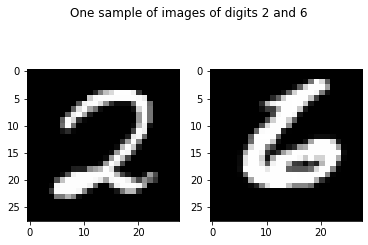

In [5]:
#Visualize one sample of digot 2 and one sample of digit 6
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('One sample of images of digits 2 and 6')
ax1.imshow((data[:,1].reshape((pixels_per_dimension, pixels_per_dimension))).T, cmap='gray')
ax2.imshow((data[:,-1].reshape((pixels_per_dimension, pixels_per_dimension))).T, cmap='gray')

There are 3 major steps in this algorith. 
1. Initialization : Initializing the Σ, μ  and Pi.
2. E-Step : Updating the weight(responsibilities)
3. M-Step : Updating Σ, μ  and Pi

So in a more mathematical notation and for multidimensional cases (here the single mean value μ for the calculation of each gaussian changes to a mean vector μ with one entry per dimension and the single variance value σ2 per gaussian changes to a mxm covariance matrix Σ where m is the number of dimensions in the dataset.) 

In the initialization step, I used random Gaussian vector with zero mean as random initial means, and two identity matrices $I$ as initial covariance matrices for the clusters, and value of 0.5 for Phi in each cluster.

In [6]:
# initialize Pi, Mu and Sigma for the clusters
def initialize(X, k):
    shape = X.shape        # 1990x784
    n, m = X.shape         # n =1990, m =784

    phi_arr = np.full(shape=(k,1) , fill_value=1/k)             # with shape (2x1)
    np.random.seed(42)
    mu_arr  = np.asmatrix(np.random.normal(0, 1, (k,m)))        # with shape (2x784   each cluster 1x784)
    sigma_arr =  np.array([np.asmatrix(np.identity(m), dtype=np.float64) for i in range(k)])   # with shape (2x784x784)
    return phi_arr, mu_arr, sigma_arr
  
def get_eig(X, r):
    """
    get eigenvals and eigenvectors
    :param data: nxn square matrix
    :param n_components: number of components for projection
    :return: eigenvectors corresponding to largest eigenvals of shape (n_components, n)
    """
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_val, eig_vec = np.linalg.eigh(X)
    eig_pairs = [(np.abs(eig_val[i]), eig_vec[:, i]) for i in range(len(eig_val))]

    # Select n_components eigenvectors with largest eigenvalues, obtain subspace transform matrix
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_pairs = np.array(eig_pairs)
    matrix_w  = np.hstack([eig_pairs[i, 1].reshape(X.shape[1], 1) for i in range(r)])  # v~784x1  w~784x10
    matrix_s  = np.hstack([eig_pairs[i, 0] for i in range(r)])                         # l~1       s~,10


    # Return samples in new subspace
    return matrix_s, matrix_w



The difference of the following algorithm with the EM algorithms is that in order to avoid numerical issues due to calculation of inverse of covariance matrix, a speed up process is used.
In this process, a dimension (r) << d is used, the eigenvalues and vectors of the covariance matrix is calculated, and the r largest eigenvalues and corresponding eigenvectors are picked. A transformed matrix of X (data) and Mu is calculated using the picked eigenvectors and the weights are calculated using these transformed matrices as shown in the code below.


In [7]:
# set the constants for the EM algorithm
k = 2            # number of classes
r = 50           # new dimension
X = data.T       # data with shape (1990, 784)
max_iter = 30    # maximum number of ietartion
shape = X.shape  # 1990x784
n, m = X.shape   # n =1990, m =784

In [8]:

phi_arr, mu_arr, sigma_arr = initialize(X, k)

logging.debug("phi_arr shape {}".format (phi_arr.shape)) 
logging.debug("mu_arr shape {}".format (mu_arr.shape))  
logging.debug("sigma_arr shape {}".format (sigma_arr.shape))  

llhood = []  #log likelihood

for iteration in range(max_iter):
    logging.debug("\n ****** ITER {} ******\n".format (iteration+1))
#     logging.debug("\n ****** E STEP  ******\n")
    # e-step
    # a.Calculate the r largest eigen values of Sigma
    numerator = []
    for c in range (k):
#         logging.debug("\n ****** CLASS {} ******\n".format (c+1))
        # get r largest eigenvals and vectors
        S, V = get_eig(sigma_arr[c], r)
         
#         logging.debug("eigenval shape {}".format (S.shape))  
#         logging.debug("eigenval  {}".format (S))  
#         logging.debug("eigenval PI MULT {}".format (np.product(S))   )
#         logging.debug("eigen vect shape {}".format (V.shape))  
        
        # b.Calculate X_tran, Mu_tran       X*WigenVectors
        x_tran = X@V
#         logging.debug("x_tran shape {}".format (x_tran.shape))  

        mu_tran = mu_arr[c]@V
#         logging.debug("mu_tran shape {}".format (mu_tran.shape)) 

        #pdb.set_trace()
        # calculate weights(responsibilities) for each observation
        dist = np.exp ((-0.5*np.sum( np.square(x_tran-mu_tran)/S.reshape(1,-1), axis=1) )) / np.sqrt(np.prod(S))
#         logging.debug("dist shape {}".format (np.shape(dist))) # shape 1990x1
        numerator.append ( phi_arr[c,0]* dist ) 
   
#   logging.debug("\n ****** M STEP  ******\n")
    denominator = np.array(numerator).sum(axis=0)
    
#     logging.debug("numerator shape {}".format (np.shape(numerator))) # 2, 1990x1
#     logging.debug("denominator shape {}".format (denominator.shape)) # 1 x1990

    
    weights = []
    for c in range (k):
        weights.append (numerator [c]/denominator)
    
    # calculate log likelihood
    log_likelihood = np.log(denominator).sum()
    logging.debug("\n log likelihood {}".format (log_likelihood))

    # m-step
    for c in range(k):
        weight = weights[c]
        
#         logging.debug("weight shape {}".format (weight.shape))   # 1x1990
#         logging.debug("weight Unique {}".format (np.unique(weight)))   # 1x1990
        
        total_weight = weight.sum()
        

        # update phi_arr
        phi_arr[c] = (weight.mean(axis=0))
        logging.debug("phi {}".format (phi_arr[c]))

        # udate Mu
        p = weight.T@X        
        mu_arr[c] = p / total_weight  # p.sum(axis=0)
#         logging.debug("\n ****** M STEP (Cont'd)  ******\n")
#         logging.debug("mu shape {}".format (mu_arr[c].shape)) #1x784

#         logging.debug("mu #NonZero {}".format (np.count_nonzero(mu_arr[c])) )
        
        
        # update Sigma
        sigma_arr[c] =((np.multiply (weight, (X-mu_arr[c]))).T@  (X-mu_arr[c]))/ total_weight

#         logging.debug("sig_arr shape {}".format (sigma_arr[c].shape))        
#         logging.debug("sig_arr #NonZero {}".format (np.count_nonzero(sigma_arr[c])) )
#         logging.debug("sig_arr Det {}".format (np.linalg.det(sigma_arr[c])))

    llhood.append(log_likelihood)
    
# get class labels
labels = np.argmax(weights, axis=0)
# logging.debug("weights shape for argmax {}".format (np.shape(labels)))


DEBUG:root:phi_arr shape (2, 1)
DEBUG:root:mu_arr shape (2, 784)
DEBUG:root:sigma_arr shape (2, 784, 784)
DEBUG:root:
 ****** ITER 1 ******

DEBUG:root:
 log likelihood -40129.81077285815
DEBUG:root:phi [0.04272406]
DEBUG:root:phi [0.95727594]
DEBUG:root:
 ****** ITER 2 ******

DEBUG:root:
 log likelihood -16839.30285402858
DEBUG:root:phi [0.05096359]
DEBUG:root:phi [0.94903641]
DEBUG:root:
 ****** ITER 3 ******

DEBUG:root:
 log likelihood -16501.10512941739
DEBUG:root:phi [0.1176779]
DEBUG:root:phi [0.8823221]
DEBUG:root:
 ****** ITER 4 ******

DEBUG:root:
 log likelihood -14375.012072693291
DEBUG:root:phi [0.25471384]
DEBUG:root:phi [0.74528616]
DEBUG:root:
 ****** ITER 5 ******

DEBUG:root:
 log likelihood -12610.379788377331
DEBUG:root:phi [0.35684355]
DEBUG:root:phi [0.64315645]
DEBUG:root:
 ****** ITER 6 ******

DEBUG:root:
 log likelihood -11294.119227389881
DEBUG:root:phi [0.42203687]
DEBUG:root:phi [0.57796313]
DEBUG:root:
 ****** ITER 7 ******

DEBUG:root:
 log likelihood -1

The final Mu vectors for each clusters (digits 2 and 6) are shown below.

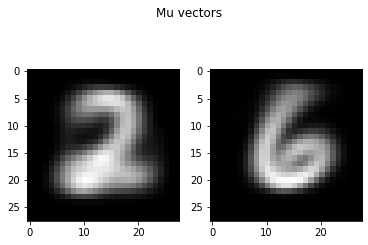

In [9]:
#plot the final Mu arrays
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Mu vectors')
ax1.imshow((mu_arr[0].reshape((28, 28))).T, cmap='gray')
ax2.imshow((mu_arr[1].reshape((28, 28))).T, cmap='gray')

The images in each clusters are averaged and the average image is shown below for each cluster.

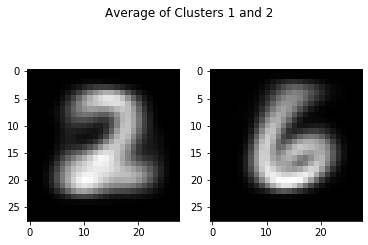

In [10]:
# average the images in each cluster
avg_cluster1 = X[(((labels).reshape(-1)) ==0),:].mean(axis = 0)
avg_cluster2 = X[(((labels).reshape(-1)) ==1),:].mean(axis = 0)
#plot the average of each cluster
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Average of Clusters 1 and 2')
ax1.imshow((avg_cluster1.reshape((28, 28))).T, cmap='gray')
ax2.imshow((avg_cluster2.reshape((28, 28))).T, cmap='gray')

Text(0, 0.5, 'log likelihood')

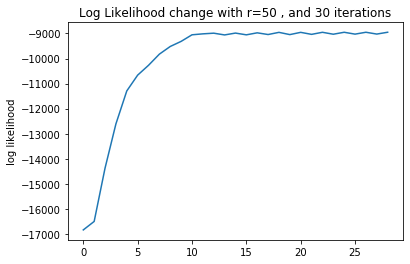

In [11]:
plt.plot(llhood[1:])
plt.title ('Log Likelihood change with r=%d , and %d iterations' %(r,max_iter))
plt.ylabel ('log likelihood')

Below, the accuarcy of the model in clustering the digits in each cluster is calculated.

In [12]:
def get_acc (trueLabel, labels):
    # change the cluster number in true Label from 2 and 6 to 0 and 1
    trueLabel[0][np.where(trueLabel[0]==2)] = 0
    trueLabel[0][np.where(trueLabel[0]==6)] = 1
    count = 0
    for i in range (n):
        if labels.T[0][i] == 0:
             if trueLabel[0][i] == 0:
                count +=1
    count
    acc_c1 = count/len(np.where (trueLabel[0]==0)[0])


    count = 0
    for i in range (n):
        if labels.T[0][i] == 1:
             if trueLabel[0][i] == 1:
                count +=1
    count
    acc_c2 = count/len(np.where (trueLabel[0]==1)[0])

    return (round(acc_c1*100,2),round(acc_c2*100,2))

print ("The accuracy of clusters 1 and 2 are correspondingly %s percents" % str (get_acc (trueLabel, labels)))

The accuracy of clusters 1 and 2 are correspondingly (96.71, 91.44) percents


In [13]:
count1 = 0
for i in range (n):
    if labels.T[0][i] == 0:
         if trueLabel[0][i] == 0:
            count1 +=1
count1
trueLabel[0][i]

1

Apart from the GMM algorithm shown above, the Kmeans algorithm using the code written in a previous HW and the package is used for clustering the model and comparing the accuracies.

# Clustering Using K-means

In [14]:
#Kmeans Algorithm
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import time
from scipy.spatial import distance

class Kmeans:
    '''Implementing Kmeans algorithm.'''

    def __init__(self, n_clusters, max_iter, random_state, metric, minkowski_p ):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = random_state
        self.metric = metric
        self.minkowski_p = minkowski_p    
         
    # define the initiation function (random starting points)
    def initializ_centroids(self, X):
        np.random.RandomState(self.random_state)
        random_idx = np.random.permutation(X.shape[0])
        centroids = X[random_idx[:self.n_clusters]]
#         print ('initial centroids are \n  %s' % centroids )
        return centroids
    
    # define the function to compute centroids based on the labels
    def compute_centroids(self, X, labels):
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            centroids[k, :] = np.mean(X[labels == k, :], axis=0)
        return centroids
    
    # define the function to calculate the distance to the centroids
    def compute_distance(self, X, centroids,metric, p):
    # make sure the medoid is always a 2D array for the function to work
        if len(centroids.shape) == 1: 
            centroids = centroids.reshape(1,-1)
        S = distance.cdist(X, centroids, 'minkowski', minkowski_p)
        return S

    
    # define the function to assign the labels
    def find_closest_cluster(self, S):
        return np.argmin(S, axis=1)

    # define the function to calculate SSE
    def compute_sse(self, X, labels, centroids):
        S = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            S[labels == k] = norm(X[labels == k] - centroids[k], axis=1)
        return np.sum(np.square(S))

    # define the function to fit the data
    def fit(self, X):
        self.centroids = self.initializ_centroids(X)
        for i in range(self.max_iter):
            old_centroids = self.centroids
            S = self.compute_distance(X, old_centroids,  'minkowski', minkowski_p)
            self.labels = self.find_closest_cluster(S)
            self.centroids = self.compute_centroids(X, self.labels)
            # converges if the centroids do not change
            if np.all(old_centroids == self.centroids):
                break
        self.error = self.compute_sse(X, self.labels, self.centroids)
 
    def predict(self, X):
        S = self.compute_distance(X, self.centroids,  'minkowski', minkowski_p)
        return self.find_closest_cluster(S)

In [15]:
# Please set the input parameters for Kmeans:
minkowski_p = 2                # distance function metric (p=1 : manhattan , P=2 : Euclidean,.. ) 
random_state = 42            # seed value to generate unique random vals


# Run Kmean algorithm
start = time.time()
km = Kmeans(k , max_iter, random_state,  'minkowski', minkowski_p )
km.fit(X)
pred_labels = km.predict(X)
end = time.time()
print ('Elapsed time to run Kmeans algorithm is %f seconds \n ' % float(end - start) )


Elapsed time to run Kmeans algorithm is 9.941132 seconds 
 


In [16]:
# average the images in each cluster
avg_cluster1 = X[(((pred_labels).reshape(-1)) ==0),:].mean(axis = 0)
avg_cluster2 = X[(((pred_labels).reshape(-1)) ==1),:].mean(axis = 0)

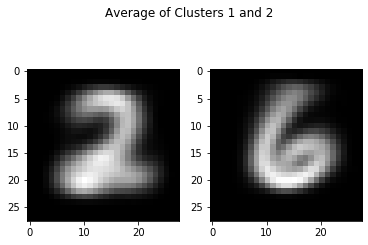

In [17]:
#plot the average of each cluster
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Average of Clusters 1 and 2')
ax1.imshow((avg_cluster1.reshape((28, 28))).T, cmap='gray')
ax2.imshow((avg_cluster2.reshape((28, 28))).T, cmap='gray')

In [18]:
#Accuracy:
def get_acc_kmeans (predlab, trueLabel):
    # change the cluster number in true Label from 2 and 6 to 0 and 1
    trueLabel[0][np.where(trueLabel[0]==2)] = 0
    trueLabel[0][np.where(trueLabel[0]==6)] = 1
    count = 0
    for i in range (n):
        if predlab[i] == 0:
             if trueLabel[0][i] == 0:
                count +=1
    count
    acc_c1 = count/len(np.where (trueLabel[0]==0)[0])


    count = 0
    for i in range (n):
        if predlab[i] == 1:
             if trueLabel[0][i] == 1:
                count +=1
    count
    acc_c2 = count/len(np.where (trueLabel[0]==1)[0])

    return (round(acc_c1*100,2),round(acc_c2*100,2))

print ("The accuracy of clusters 1 and 2 are correspondingly" ,str(get_acc_kmeans (pred_labels, trueLabel)))

The accuracy of clusters 1 and 2 are correspondingly (94.57, 92.9)


# Clustering Using Kmeans Package

In [19]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, ..., 1, 0, 0])

In [20]:
# average the images in each cluster
avg_cluster1 = X[(((kmeans.labels_).reshape(-1)) ==1),:].mean(axis = 0)
avg_cluster2 = X[(((kmeans.labels_).reshape(-1)) ==0),:].mean(axis = 0)

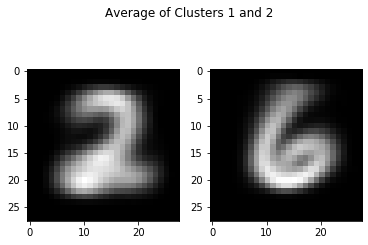

In [21]:
#plot the average of each cluster
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Average of Clusters 1 and 2')
ax1.imshow((avg_cluster1.reshape((28, 28))).T, cmap='gray')
ax2.imshow((avg_cluster2.reshape((28, 28))).T, cmap='gray')

# Summary of Findings

As shown above the GMM algorithm was applied to a dataset of 1990 images. Each image represents either digit 2 or 6 handwritings vectorized in a 784 vector.
The speed up algorithms lets us use a dimension much smallwer that 784 for the calculations.

Although at lower r , there is reasonable clustering accuracy, but in general it is lower than kmeans. As r increases the accuracy of the clustering increases as well. The X~ is the approximation of X so as r increases more variability of the data will be caught. Ar r=784, GMM will have its real accuracy which will be higher than K means, as instead of having 1 and 0 as the weight, a probibility will be assigned to each observation. Also, Kmeans takes longer runtime in comparison with the speed-up GMM.

It should be noted, that GMM might return a local opitmum, that is why the initialization is very important. Changing the initial random Mu vectors , changes the final results.


| r | Cluster 1 Accuracy (GMM) | Cluster 2 Accuracy (GMM) |Cluster 1 Accuracy (Kmenas) | Cluster 2 Accuracy (Kmeans) |
| --- | --- | --- | --- | --- |
| 5 | 70 | 76 |94 | 93|
| 10 | 76 | 96 |94 | 93|
| 30 | 88| 86 |94 | 93|
| 50 | 97| 91 |94 | 93|